In [1]:
import yfinance as yf
import pandas as pd

data = yf.download("AAPL", start="2015-01-01", end="2023-01-01", auto_adjust=True)

data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]


data = data[['Close_AAPL']].copy()  

data.dropna(subset=['Close_AAPL'], inplace=True)

print(data.head())

data.to_csv("AAPL_stock_data.csv", index_label="Date")

data.to_excel("AAPL_stock_data.xlsx", index_label="Date")


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Empty DataFrame
Columns: [Close_AAPL]
Index: []


In [1]:
import pandas as pd

df = pd.read_csv("AAPL_stock_data.csv", skiprows=0, parse_dates=['Date'], index_col='Date')

df.columns = ['Close']

df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

df = df.dropna(subset=['Close'])

print(df.head())
print(df.info())

                Close
Date                 
2015-01-02  24.261055
2015-01-05  23.577574
2015-01-06  23.579790
2015-01-07  23.910435
2015-01-08  24.829126
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2014 entries, 2015-01-02 to 2022-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2014 non-null   float64
dtypes: float64(1)
memory usage: 31.5 KB
None


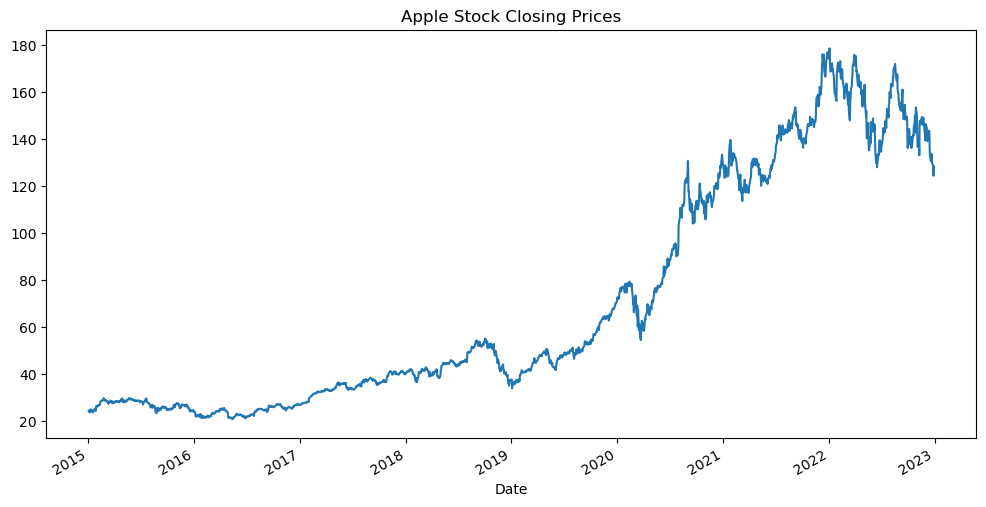

ADF Statistic: -0.6303067985116851
p-value: 0.8639858434129919


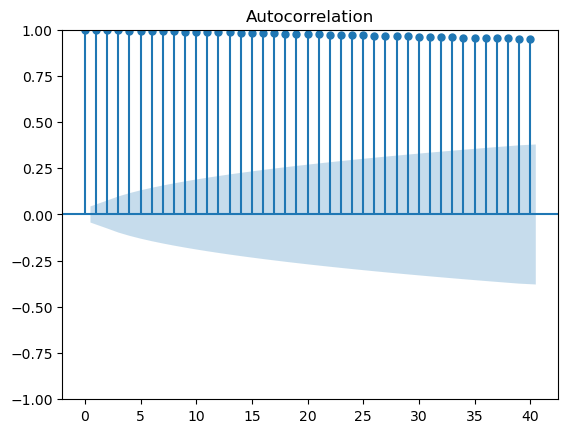

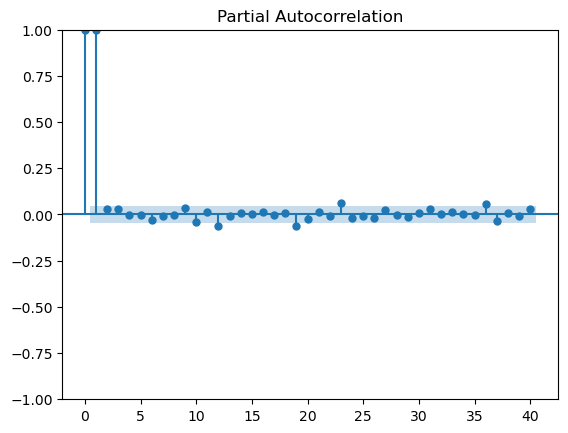

In [3]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df['Close'].plot(figsize=(12,6), title="Apple Stock Closing Prices")
plt.show()

result = adfuller(df['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

plot_acf(df['Close'], lags=40)
plot_pacf(df['Close'], lags=40)
plt.show()


C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Hp\anac

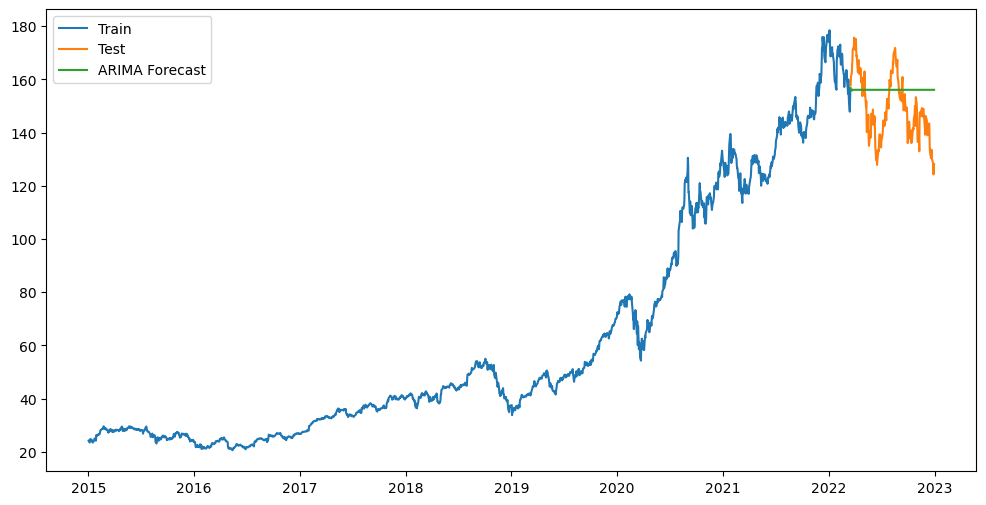

In [5]:
from statsmodels.tsa.arima.model import ARIMA

train = df['Close'][:-200]
test = df['Close'][-200:]

model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast')
plt.legend()
plt.show()


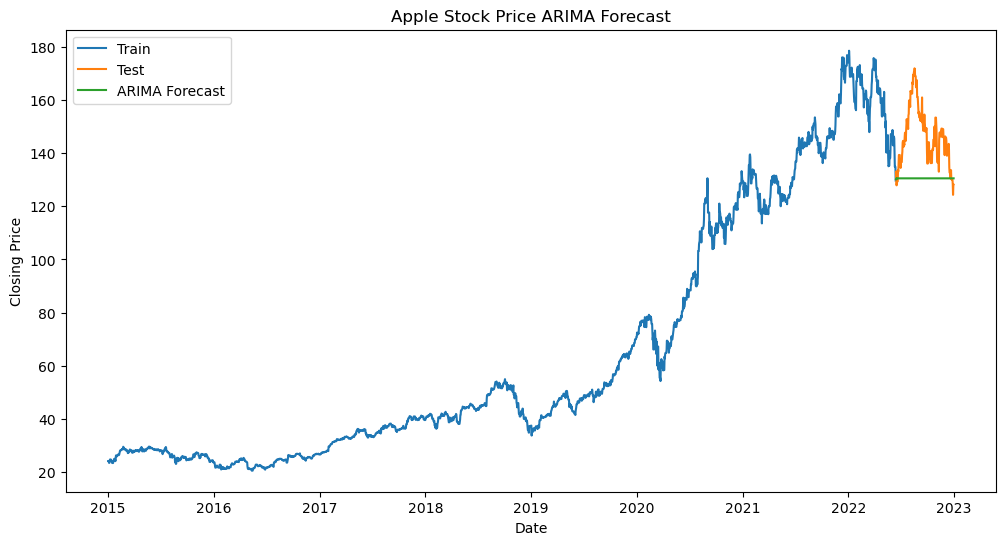

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv("AAPL_stock_data.csv", parse_dates=['Date'], index_col='Date')

df.columns = ['Close']

df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])

df = df.resample('D').ffill()

train = df['Close'][:-200]
test = df['Close'][-200:]

model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast')
plt.title("Apple Stock Price ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

In [9]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Close']])

def create_sequences(df, seq_len=60):
    X, y = [], []
    for i in range(len(df)-seq_len):
        X.append(df[i:i+seq_len])
        y.append(df[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(scaled, seq_len)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_len,1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

pred = model.predict(X_test)
pred = scaler.inverse_transform(pred)

n_future = 10 
future_preds = []

last_seq = X_test[-1]  
current_seq = last_seq

for _ in range(n_future):
    next_pred = model.predict(current_seq.reshape(1, seq_len, 1))[0]
    future_preds.append(next_pred)
    current_seq = np.vstack([current_seq[1:], next_pred])

future_preds = scaler.inverse_transform(np.array(future_preds))

print("Next", n_future, "day predictions:")
print(future_preds.flatten())


Epoch 1/10


C:\Users\Hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 1.8116e-04 - val_loss: 0.0019
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 1.7415e-04 - val_loss: 8.5264e-04
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 1.6070e-04 - val_loss: 5.4485e-04
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 1.4658e-04 - val_loss: 7.1092e-04
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 1.4025e-04 - val_loss: 4.8825e-04
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 1.4351e-04 - val_loss: 7.8612e-04
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 1.4281e-04 - val_loss: 6.4968e-04
Epoch 9/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 1.2673e-04 - val_loss: 8.1355e-04
Epoch 10/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 1.2513e-04 - val_loss: 4.4610e-04
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━

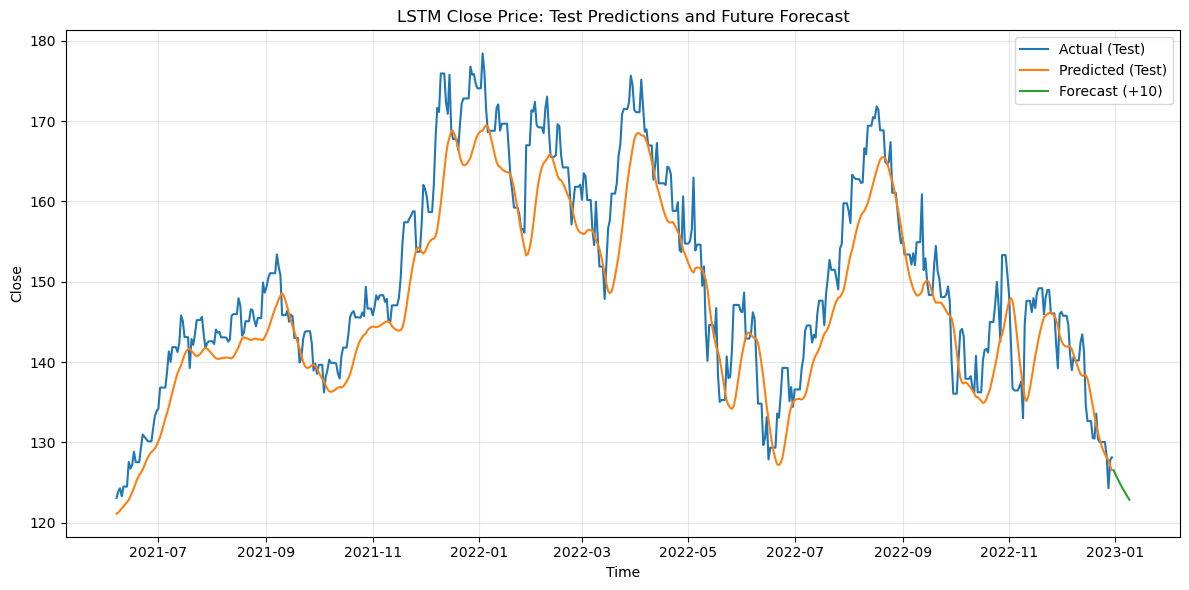

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

y_test_inv = scaler.inverse_transform(y_test)

N = len(scaled) - seq_len  
start_test_y_idx = seq_len + split
end_test_y_idx = start_test_y_idx + len(y_test)

if isinstance(df.index, pd.DatetimeIndex):
    y_test_index = df.index[start_test_y_idx:end_test_y_idx]
else:
    y_test_index = np.arange(start_test_y_idx, end_test_y_idx)

actual_test_series = pd.Series(y_test_inv.ravel(), index=y_test_index)
pred_test_series   = pd.Series(pred.ravel(), index=y_test_index)

if isinstance(df.index, pd.DatetimeIndex):
    last_date = y_test_index[-1]
    freq = df.index.freq if df.index.freq is not None else (df.index.inferred_freq or 'D')
    future_index = pd.date_range(start=last_date, periods=len(future_preds) + 1, freq=freq)[1:]
else:
    last_idx = y_test_index[-1]
    future_index = np.arange(last_idx + 1, last_idx + 1 + len(future_preds))

future_series = pd.Series(future_preds.ravel(), index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(actual_test_series.index, actual_test_series.values, label='Actual (Test)')
plt.plot(pred_test_series.index,   pred_test_series.values,   label='Predicted (Test)')
plt.plot(future_series.index,      future_series.values,      label=f'Forecast (+{len(future_preds)})')
plt.title('LSTM Close Price: Test Predictions and Future Forecast')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def safe_metrics(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float).ravel()
    y_pred = np.asarray(y_pred, dtype=float).ravel()

    n = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:n], y_pred[:n]

    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true, y_pred = y_true[m], y_pred[m]
    if y_true.size == 0:
        return np.nan, np.nan

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps)))
    return float(rmse), float(mape)

if "Close" not in df.columns:
    raise ValueError("'Close' column not found.")

y = df["Close"].astype(float)

test_size = 60
train, test = y.iloc[:-test_size], y.iloc[-test_size:]

model = ARIMA(train, order=(5,1,0), enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(method_kwargs={"warn_convergence": False})

forecast = res.forecast(steps=len(test))     

arima_rmse, arima_mape = safe_metrics(test.values, forecast.values)

print("ARIMA RMSE:", arima_rmse)
print("ARIMA MAPE:", arima_mape)


ARIMA RMSE: 12.955494218221505
ARIMA MAPE: 0.08013550160453459


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

y_test_aligned = y_test_inv[-len(pred):]

lstm_rmse = np.sqrt(mean_squared_error(y_test_aligned, pred))
lstm_mape = mean_absolute_percentage_error(y_test_aligned, pred)

print("LSTM RMSE:", lstm_rmse)
print("LSTM MAPE:", lstm_mape)

LSTM RMSE: 5.368768560001166
LSTM MAPE: 0.027944501482564454


In [25]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def rolling_window_arima(series, window_size=200, forecast_horizon=1):
    errors_rmse, errors_mape = [], []

    series = np.array(series)

    for i in range(window_size, len(series) - forecast_horizon):
        train = series[i-window_size:i]
        test = series[i:i+forecast_horizon]

        try:
            model = ARIMA(train, order=(5,1,0))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=forecast_horizon)

            rmse = np.sqrt(mean_squared_error(test, forecast))
            mape = mean_absolute_percentage_error(test, forecast)

            errors_rmse.append(rmse)
            errors_mape.append(mape)
        except Exception as e:
            continue

  
    if len(errors_rmse) == 0:
        return np.nan, np.nan

    return np.mean(errors_rmse), np.mean(errors_mape)

arima_rmse_roll, arima_mape_roll = rolling_window_arima(df['Close'], window_size=200)
print("ARIMA Rolling RMSE:", arima_rmse_roll)
print("ARIMA Rolling MAPE:", arima_mape_roll)



C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Rolling RMSE: 0.7900705786191281
ARIMA Rolling MAPE: 0.009881837288304923


In [27]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view 
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential, Input 


def _make_seq_xy(arr_2d, seq_len, horizon=1):
    """
    arr_2d: shape (N, 1)
    Returns X: (N-seq_len-horizon+1, seq_len, 1), y: (N-seq_len-horizon+1, 1)
    """
    if arr_2d.ndim != 2 or arr_2d.shape[1] != 1:
        raise ValueError("arr_2d must have shape (N, 1)")
    if len(arr_2d) <= seq_len + horizon -1: 
        return np.empty((0, seq_len, 1)), np.empty((0, 1))

    X = sliding_window_view(arr_2d[:, 0], seq_len)

 
    y = arr_2d[seq_len:]

    
    if horizon > 0:
        X = X[:-horizon]
        y = y[horizon-1:-horizon+1]

    X = X[..., None] 

    
    y = arr_2d[seq_len + horizon - 1: len(arr_2d) - (horizon - 1 if horizon > 1 else 0)]
    y = y[:len(X)] 

    return X, y


def _make_dataset(X, y, batch_size=64, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X.astype(np.float32), y.astype(np.float32)))
    if shuffle:
        ds = ds.shuffle(min(len(X), 2048), seed=42)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

def build_lstm(seq_len=60, units=32):
    model = Sequential([
        Input(shape=(seq_len, 1)),
        LSTM(units, return_sequences=True),
        LSTM(units),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def rolling_window_lstm_fast(
    data,                   
    seq_len=60,
    window_size=200,
    horizon=1,
    base_epochs=5,          
    update_epochs=1,       
    train_every=10,         
    batch_size=64,
    units=32,
    use_global_scaler=True,  
    verbose=False
):
    """
    Returns: (avg_RMSE, avg_MAPE) over all rolling steps
    Much faster than rebuilding a model per step.
    """

   
    data = np.asarray(data)
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    if data.shape[1] != 1:
        raise ValueError("data must be a single column array of shape (N,1)")

    N = len(data)
    if N < window_size + seq_len + horizon:
        raise ValueError("Not enough data for the requested window_size/seq_len/horizon.")

   
    global_scaler = MinMaxScaler()
    if use_global_scaler:
        scaled_all = global_scaler.fit_transform(data)
    else:
        scaled_all = None  

   
    model = build_lstm(seq_len=seq_len, units=units)

    errors_rmse, errors_mape = [], []

    total_steps = (N - horizon) - window_size  
    
    start = window_size
    end = start  
    subset = data[start - window_size:start] 

    if use_global_scaler:
        subset_scaled = scaled_all[start - window_size:start]
    else:
        scaler = MinMaxScaler()
       
        fit_end = len(subset) - horizon
        scaler.fit(subset[:fit_end])
        subset_scaled = scaler.transform(subset)

    X, y = _make_seq_xy(subset_scaled, seq_len, horizon=horizon)
    if len(X) == 0:
        return np.nan, np.nan

    
    X_train, y_train = X[:-horizon], y[:-horizon]
    X_test,  y_test  = X[-horizon:], y[-horizon:]

  
    ds_train = _make_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
    cb = [tf.keras.callbacks.EarlyStopping(monitor="loss", patience=2, min_delta=1e-5, restore_best_weights=True)]
    model.fit(ds_train, epochs=base_epochs, verbose=0, callbacks=cb)

    
    pred = model.predict(X_test, verbose=0)
   
    if use_global_scaler:
        pred_inv = global_scaler.inverse_transform(pred)
        y_inv    = global_scaler.inverse_transform(y_test)
    else:
        scaler.inverse_transform(pred) 
        y_inv = scaler.inverse_transform(y_test)

    errors_rmse.append(np.sqrt(mean_squared_error(y_inv, pred_inv)))
    errors_mape.append(mean_absolute_percentage_error(y_inv, pred_inv))

    if verbose:
        print(f"Processed window 1/{total_steps}")

    
    for step, i in enumerate(range(window_size + 1, N - horizon), start=2):
        subset = data[i - window_size:i]

        if use_global_scaler:
            subset_scaled = scaled_all[i - window_size:i]
        else:
            scaler = MinMaxScaler()
            fit_end = len(subset) - horizon
            scaler.fit(subset[:fit_end])
            subset_scaled = scaler.transform(subset)

        X, y = _make_seq_xy(subset_scaled, seq_len, horizon=horizon)
        if len(X) == 0:
            continue

        X_train, y_train = X[:-horizon], y[:-horizon]
        X_test,  y_test  = X[-horizon:], y[-horizon:]

      
        if (step - 1) % train_every == 0:
            ds_train = _make_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
            model.fit(ds_train, epochs=update_epochs, verbose=0)

        pred = model.predict(X_test, verbose=0)

        if use_global_scaler:
            pred_inv = global_scaler.inverse_transform(pred)
            y_inv    = global_scaler.inverse_transform(y_test)
        else:
            
            pred_inv = scaler.inverse_transform(pred)
            y_inv = scaler.inverse_transform(y_test)


        errors_rmse.append(np.sqrt(mean_squared_error(y_inv, pred_inv)))
        errors_mape.append(mean_absolute_percentage_error(y_inv, pred_inv))

        if verbose and (step % 20 == 0 or step == total_steps):
            print(f"Processed window {step}/{total_steps}")

        if step >= total_steps:
            break


    if not errors_rmse:
        return np.nan, np.nan
    return float(np.mean(errors_rmse)), float(np.mean(errors_mape))


if "Close" in df.columns:
    lstm_rmse_roll, lstm_mape_roll = rolling_window_lstm_fast(
        df[['Close']].values,
        seq_len=60,
        window_size=200,
        horizon=1,
        base_epochs=5,       
        update_epochs=1,     
        train_every=10,      
        batch_size=128,      
        units=32,           
        use_global_scaler=True,  
        verbose=True
    )
    print("Rolling LSTM RMSE:", lstm_rmse_roll)
    print("Rolling LSTM MAPE:", lstm_mape_roll)
else:
    print(" Error: 'Close' column not found in data.")

Processed window 1/2719
Processed window 20/2719
Processed window 40/2719
Processed window 60/2719
Processed window 80/2719
Processed window 100/2719
Processed window 120/2719
Processed window 140/2719
Processed window 160/2719
Processed window 180/2719
Processed window 200/2719
Processed window 220/2719
Processed window 240/2719
Processed window 260/2719
Processed window 280/2719
Processed window 300/2719
Processed window 320/2719
Processed window 340/2719
Processed window 360/2719
Processed window 380/2719
Processed window 400/2719
Processed window 420/2719
Processed window 440/2719
Processed window 460/2719
Processed window 480/2719
Processed window 500/2719
Processed window 520/2719
Processed window 540/2719
Processed window 560/2719
Processed window 580/2719
Processed window 600/2719
Processed window 620/2719
Processed window 640/2719
Processed window 660/2719
Processed window 680/2719
Processed window 700/2719
Processed window 720/2719
Processed window 740/2719
Processed window 7

In [29]:
import warnings
warnings.filterwarnings("ignore")  

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA

def _get_if_defined(name, default=np.nan):
    try:
        return eval(name)
    except NameError:
        return default


def rolling_window_arima(series, window_size=200, forecast_horizon=1, order=(5,1,0)):
    """
    Walks forward one step at a time.
    For each position: fit ARIMA on the last `window_size` points; forecast `forecast_horizon`.
    Returns mean RMSE/MAPE across all steps (ignores steps that failed to fit).
    """
    errors_rmse, errors_mape = [], []

    series = np.asarray(series, dtype=np.float64).ravel()
    if len(series) < window_size + forecast_horizon:
        return np.nan, np.nan

    for i in range(window_size, len(series) - forecast_horizon + 1):
        train = series[i-window_size:i]
        test  = series[i:i+forecast_horizon]
        try:
            model = ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(method_kwargs={"warn_convergence": False})
            forecast = model_fit.forecast(steps=forecast_horizon)
            rmse = np.sqrt(mean_squared_error(test, forecast))
            mape = mean_absolute_percentage_error(test, forecast)
            errors_rmse.append(rmse)
            errors_mape.append(mape)
        except Exception:
           
            continue

    if not errors_rmse:
        return np.nan, np.nan
    return float(np.mean(errors_rmse)), float(np.mean(errors_mape))


def holdout_arima(series, test_size=60, order=(5,1,0)):
    """
    Fit ARIMA on all but last `test_size` points; forecast next `test_size`.
    Returns RMSE, MAPE on the holdout.
    """
    series = np.asarray(series, dtype=np.float64).ravel()
    if len(series) <= test_size + 5: 
        return np.nan, np.nan

    train, test = series[:-test_size], series[-test_size:]
    try:
        model = ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(method_kwargs={"warn_convergence": False})
        forecast = model_fit.forecast(steps=len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mape = mean_absolute_percentage_error(test, forecast)
        return float(rmse), float(mape)
    except Exception:
        return np.nan, np.nan


if "Close" not in df.columns:
    raise ValueError(" Error: 'Close' column not found in data.")

close_series = df["Close"].astype(float).values


arima_rmse, arima_mape = holdout_arima(close_series, test_size=60, order=(5,1,0))
arima_rmse_roll, arima_mape_roll = rolling_window_arima(close_series, window_size=200, forecast_horizon=1, order=(5,1,0))


lstm_rmse        = _get_if_defined("lstm_rmse",        np.nan)
lstm_mape        = _get_if_defined("lstm_mape",        np.nan)
lstm_rmse_roll   = _get_if_defined("lstm_rmse_roll",   np.nan)
lstm_mape_roll   = _get_if_defined("lstm_mape_roll",   np.nan)


results = {
    "Model": ["ARIMA", "LSTM"],
    "RMSE": [arima_rmse, lstm_rmse],
    "MAPE": [arima_mape, lstm_mape],
    "Rolling RMSE": [arima_rmse_roll, lstm_rmse_roll],
    "Rolling MAPE": [arima_mape_roll, lstm_mape_roll],
}

df_results = pd.DataFrame(results)

df_results_fmt = df_results.copy()
for col in ["RMSE", "MAPE", "Rolling RMSE", "Rolling MAPE"]:
    df_results_fmt[col] = df_results_fmt[col].apply(lambda x: f"{x:.4f}" if pd.notnull(x) else "NaN")

print(df_results_fmt)


   Model     RMSE    MAPE Rolling RMSE Rolling MAPE
0  ARIMA  12.9555  0.0801       0.7913       0.0099
1   LSTM   5.3688  0.0279       1.8990       0.0295


In [31]:
!pip install -U huggingface_hub
from huggingface_hub import login
login()  


In [33]:
import os

os.environ.pop("HF_TOKEN", None)
os.environ.pop("HUGGING_FACE_HUB_TOKEN", None)

print("Env tokens cleared.")


Env tokens cleared.


In [35]:
from huggingface_hub import logout
logout()  
print("Logged out (cleared cached token).")


Not logged in!


Logged out (cleared cached token).


In [37]:
import os
from huggingface_hub import login

login(token=os.getenv("HF_TOKEN"))


In [39]:


import os, getpass, sys
from pathlib import Path
from huggingface_hub import HfApi, login

HF_TOKEN = os.getenv("HF_TOKEN")
if not HF_TOKEN or not HF_TOKEN.startswith("hf_"):
    tok = getpass.getpass("Paste your HF token (starts with hf_): ").strip()
    if not tok.startswith("hf_"):
        raise RuntimeError("Invalid token format. Get one from https://huggingface.co/settings/tokens (Read+Write).")
    os.environ["HF_TOKEN"] = tok
    HF_TOKEN = tok

login(token=HF_TOKEN, add_to_git_credential=False)
api = HfApi(token=HF_TOKEN)

me = api.whoami()          
username = me["name"]
print(f" Authenticated as: {username}")


local_folder = Path(r"E:\Career\Data synthis\DataSynthis_ML_JobTask")  

if not local_folder.exists() or not local_folder.is_dir():
    raise FileNotFoundError(f"Folder not found: {local_folder}")


some = list(local_folder.rglob("*"))[:5]
print("Sample files:", [str(p) for p in some])


repo_name = "DataSynthis_ML_JobTask"
repo_id   = f"{username}/{repo_name}"        


repo_type = "model"


api.create_repo(repo_id=repo_id, repo_type=repo_type, exist_ok=True)
print(f" Repo ready: https://huggingface.co/{repo_id}")


res = api.upload_folder(
    folder_path=str(local_folder),
    repo_id=repo_id,
    repo_type=repo_type,
    path_in_repo="",  
)
print(" Folder uploaded. Commit:", getattr(res, "oid", res))
print(f"Open: https://huggingface.co/{repo_id}")


Paste your HF token (starts with hf_):  ········


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


 Authenticated as: azima4361
Sample files: ['E:\\Career\\Data synthis\\DataSynthis_ML_JobTask\\.ipynb_checkpoints', 'E:\\Career\\Data synthis\\DataSynthis_ML_JobTask\\AAPL_stock_data.csv', 'E:\\Career\\Data synthis\\DataSynthis_ML_JobTask\\Time_Series_Forecasting.ipynb', 'E:\\Career\\Data synthis\\DataSynthis_ML_JobTask\\.ipynb_checkpoints\\Time_Series_Forecasting-checkpoint.ipynb']
 Repo ready: https://huggingface.co/azima4361/DataSynthis_ML_JobTask
 Folder uploaded. Commit: 93eb9bc36357ce51e6451bc22f99a2b8ceef9108
Open: https://huggingface.co/azima4361/DataSynthis_ML_JobTask


In [41]:
from huggingface_hub import HfApi

api = HfApi(token=os.getenv("HF_TOKEN"))
api.upload_folder(
    folder_path="/Career/Data synthis/DataSynthis_ML_JobTask",
    repo_id="azima4361/DataSynthis_ML_JobTask",
    repo_type="model",
)


No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/azima4361/DataSynthis_ML_JobTask/commit/93eb9bc36357ce51e6451bc22f99a2b8ceef9108', commit_message='Upload folder using huggingface_hub', commit_description='', oid='93eb9bc36357ce51e6451bc22f99a2b8ceef9108', pr_url=None, repo_url=RepoUrl('https://huggingface.co/azima4361/DataSynthis_ML_JobTask', endpoint='https://huggingface.co', repo_type='model', repo_id='azima4361/DataSynthis_ML_JobTask'), pr_revision=None, pr_num=None)